# Precio del Maíz en Chile

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import arma_generate_sample, ArmaProcess
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_model import ARMA
from statsmodels.stats.diagnostic import acorr_ljungbox 
import pylab
import scipy.stats as stats


#Funciones a utilizar

def test_stationarity(timeseries):
    
    #Determinación de la media móvil
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Graficando la media móvil:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Media móvil')
    std = plt.plot(rolstd, color='black', label = 'Desviación estándar móvil')
    plt.legend(loc='best')
    plt.title('Média móvil y desviación estándar')
    plt.show(block=False)
    
    #Aplicación del test de Dickey-Fuller:
    print('Resultados del test de Dickey-Fuller:')
    dftest = adfuller(timeseries, regression="nc")
    dfoutput = pd.Series(dftest[0:4], index=['Estadístico de Prueba','valor-p','#Retardos utilizados','Número de observaciones utilizado'])
    for key,value in dftest[4].items():
        dfoutput['Valor crítico (%s)'%key] = value
    print(dfoutput)

def tsdisplay(y, figsize = (10, 10), lags = 20):
    tmp_data = pd.Series(y)
    fig = plt.figure(figsize = figsize)
    #Plot the time series
    tmp_data.plot(ax = fig.add_subplot(311), title = "Residuos de modelo", legend = False)
    #Plot the ACF:
    sm.graphics.tsa.plot_acf(tmp_data, lags = lags, zero = False, ax = fig.add_subplot(323))
    plt.xticks(np.arange(1,  lags + 1, 1.0))
    #Plot the PACF:
    sm.graphics.tsa.plot_pacf(tmp_data, lags = 20, zero = False, ax = fig.add_subplot(324))
    plt.xticks(np.arange(1,  lags + 1, 1.0))
    #Plot the QQ plot of the data:
    sm.qqplot(tmp_data, line='s', ax = fig.add_subplot(325)) 
    plt.title("QQ Plot")
    #Plot the residual histogram:
    fig.add_subplot(326).hist(tmp_data, bins = 40)
    plt.title("Histogram")
    #Fix the layout of the plots:
    plt.tight_layout()

# Carga de datos

In [5]:
df = pd.read_excel("Maíz ODEPA (4)  Precio real.xlsx", sheet_name="PRECIOS REALES MENSUALES")
df.columns = list(df.loc[0])
df.head()

,Año,Ene,IPM Ene,RAZÓN,P. REAL MENSUAL,Feb,IPM Feb,RAZÓN,P. REAL MENSUAL,Mar,...,RAZÓN,P. REAL MENSUAL,Nov,IPM Nov,RAZÓN,P. REAL MENSUAL,Dic,IPM Dic,RAZÓN,P. REAL MENSUAL
0,Año,Ene,IPM Ene,RAZÓN,P. REAL MENSUAL,Feb,IPM Feb,RAZÓN,P. REAL MENSUAL,Mar,...,RAZÓN,P. REAL MENSUAL,Nov,IPM Nov,RAZÓN,P. REAL MENSUAL,Dic,IPM Dic,RAZÓN,P. REAL MENSUAL
1,1975,280,0.26,1076.92,401025,320,0.3,1066.67,397205,350,...,757.895,282225,900,1.05,857.143,319183,920,1.09,844.037,314302
2,1976,1050,1.24,846.774,315322,1200,1.38,869.565,323809,1180,...,785.496,292503,2058,2.63,782.51,291391,2058,2.75,748.364,278676
3,1977,2058,2.94,700,260666,2058,3.21,641.121,238741,2075,...,631.121,235017,2842,4.48,634.375,236229,2842,4.54,625.991,233107
4,1978,3200,4.63,691.145,257368,3200,4.82,663.9,247223,3367,...,873.786,325381,5400,6.29,858.506,319690,5000,6.31,792.393,295071


## Obtenemos serie de precios nominales para hacer comparación con precios reales

In [6]:
meses = ['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic ']
df_nominal = df[meses]

In [7]:
df_nominal = df_nominal.drop([0])

In [8]:
df_nominal.index = list(range(len(df_nominal)))

In [9]:
precios_nominales = []
for i in range(len(df_nominal)):
    for j in range(len(df_nominal.columns)):
        precios_nominales.append(df_nominal.loc[i][j]) 

In [10]:
ts_nom = pd.DataFrame()
ts_nom["Precio"] = precios_nominales
ts_nom.index = pd.date_range("01/1975","01/2021", freq='m') 

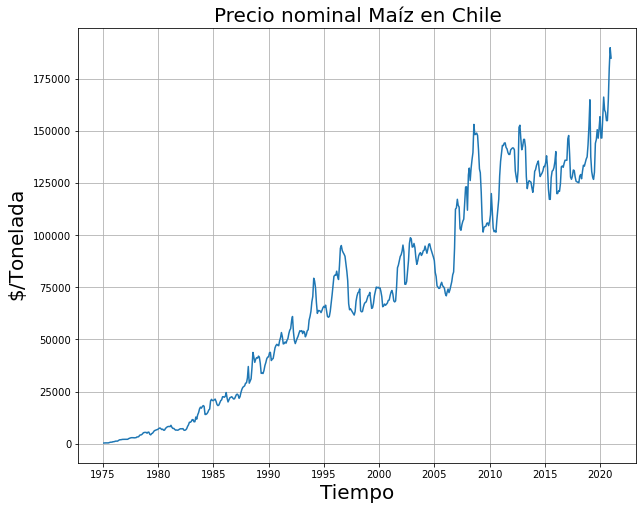

In [11]:
plt.figure(figsize=(10,8))
plt.plot(ts_nom)
plt.title("Precio nominal Maíz en Chile", fontsize=20)
plt.ylabel("$\$$/Tonelada", fontsize=20)
plt.xlabel("Tiempo", fontsize=20)
plt.grid()

## Precios Reales del maíz

In [12]:
datos = df["P. REAL MENSUAL"]
datos = datos.drop([0])
datos.index = list(range(len(datos)))

precios = []
for i in range(len(datos)):
    for j in range(len(datos.columns)):
        precios.append(datos.loc[i][j]) 

In [13]:
ts = pd.DataFrame()
ts["Precio"] = precios
ts.index = pd.date_range("01/1975","01/2021", freq='m') 

Eliminamos las 3 primeras observaciones por considerarlas outliers

In [15]:
ts = ts[3:]

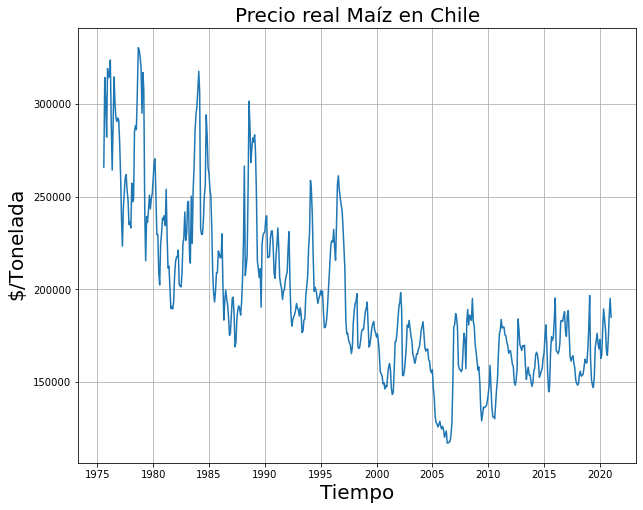

In [16]:
plt.figure(figsize=(10,8))
plt.plot(ts)
plt.title("Precio real Maíz en Chile", fontsize = 20)
plt.ylabel("$\$$/Tonelada", fontsize=20)
plt.xlabel("Tiempo", fontsize=20)
plt.grid()

## Obtención de los datos

Los datos fueron obtenidos del sitio web de la Oficina de estudios y políticas agrarias (ODEPA) del ministerio de agricultura. A los datos se les realizó un procesamiento, debido a que representaban los precios nominales, por lo que hubo que ajustarlos a precio real, considerando datos del índice de Precios al por mayor (IPM), dichos datos fueron obtenidos del Instituto Nacional de Estadísticas. Finamente trabajaremos con los datos de precio real del maíz, en periodos mensuales desde el año 1975 al año 2020



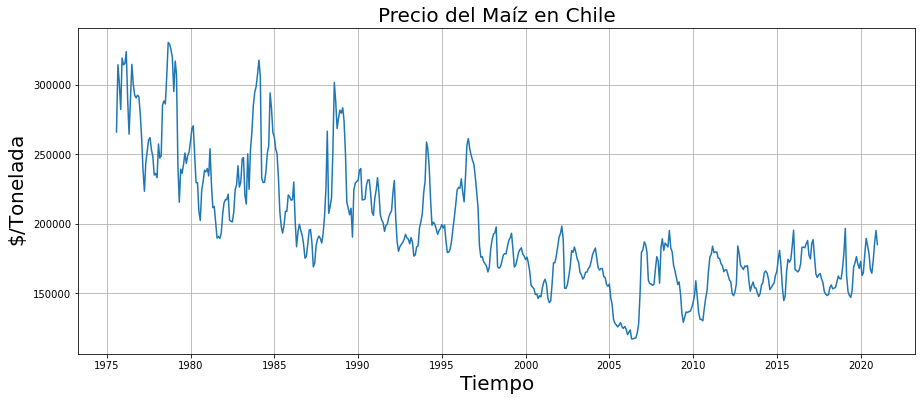

In [17]:
plt.figure(figsize=(15,6))
plt.plot(ts)
plt.title("Precio del Maíz en Chile", fontsize = 20)
plt.ylabel("$\$$/Tonelada", fontsize=20)
plt.xlabel("Tiempo", fontsize=20)
plt.grid()

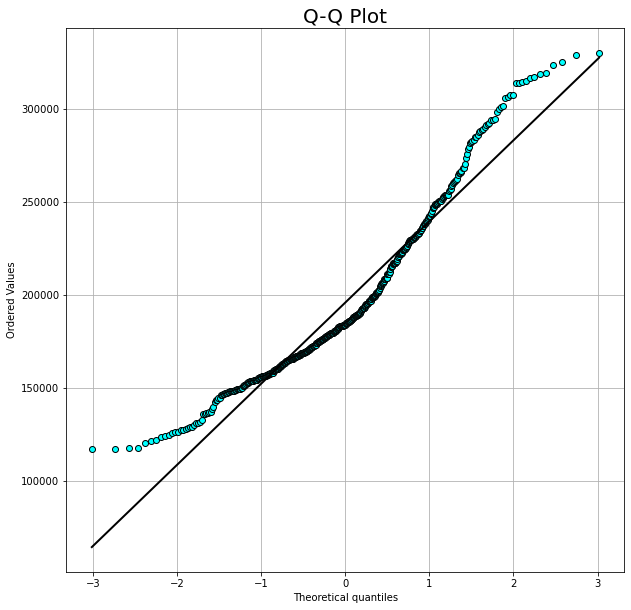

In [18]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
fig = stats.probplot(ts["Precio"].values, dist="norm", plot=pylab)
ax.get_lines()[0].set_marker('o')
ax.get_lines()[0].set_color('black')
ax.get_lines()[0].set_markerfacecolor('cyan')
ax.get_lines()[1].set_color('black')
ax.get_lines()[1].set_linewidth('2')
plt.title("Q-Q Plot", fontsize=20)
plt.grid()

In [20]:
print("Con el test de Shapiro-Wilk obtenemos un p-valor:", stats.shapiro(ts)[1])

Con el test de Shapiro-Wilk obtenemos un p-valor: 4.111098465234449e-14


<Figure size 432x288 with 0 Axes>

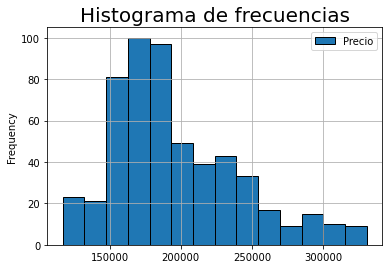

In [28]:
plt.figure()
ts.plot.hist(bins=14, edgecolor="black").get_figure()
plt.title("Histograma de frecuencias", fontsize=20)
plt.grid()

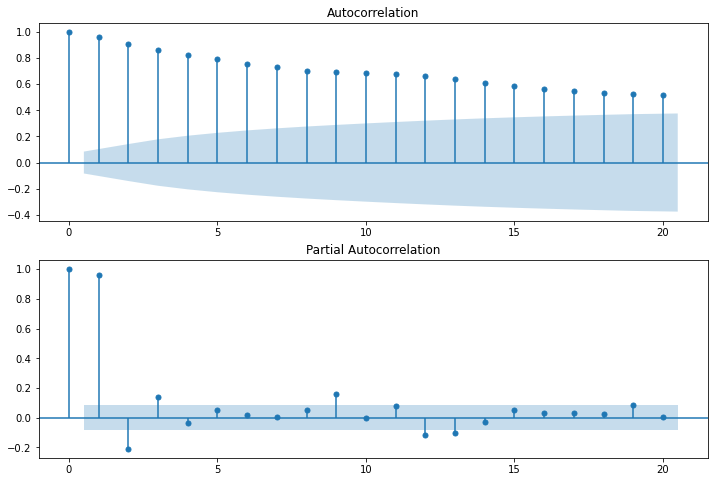

In [30]:
fig=plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig=sm.graphics.tsa.plot_acf(ts.dropna(), lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig=sm.graphics.tsa.plot_pacf(ts.dropna(), lags=20, ax=ax2)
plt.show()

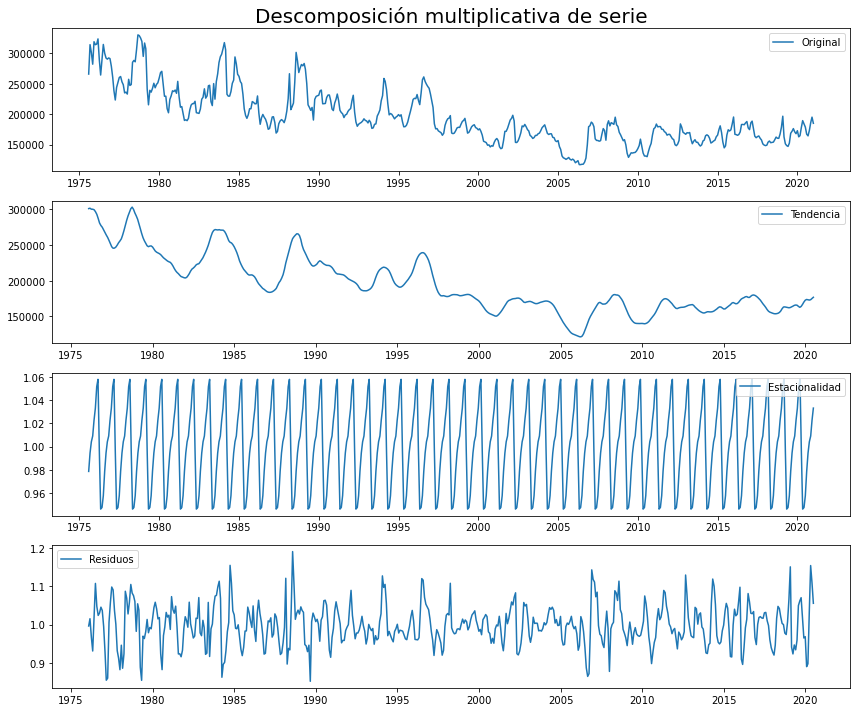

In [33]:
decomposition = seasonal_decompose(ts, model="multiplicative")

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(12,10))
plt.subplot(411)
plt.title("Descomposición multiplicativa de serie", fontsize=20)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Estacionalidad')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuos')
plt.legend(loc='best')
plt.tight_layout()

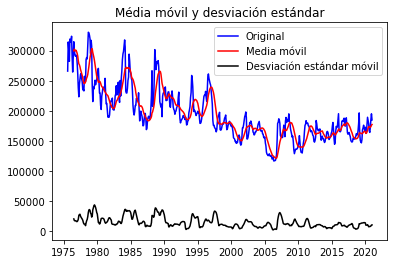

Resultados del test de Dickey-Fuller:
Estadístico de Prueba                 -1.216843
valor-p                                0.205057
#Retardos utilizados                  12.000000
Número de observaciones utilizado    533.000000
Valor crítico (1%)                    -2.569948
Valor crítico (5%)                    -1.941516
Valor crítico (10%)                   -1.616331
dtype: float64


In [34]:
test_stationarity(ts)

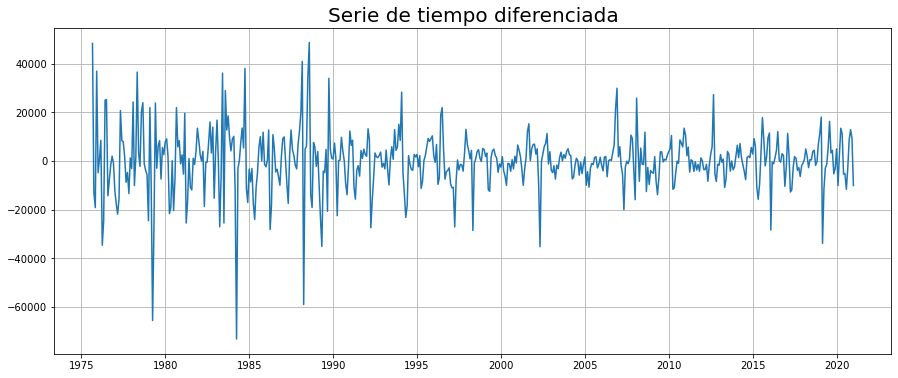

In [36]:
ts_diff = ts.diff().dropna()

plt.figure(figsize=(15,6))
plt.plot(ts_diff)
plt.title("Serie de tiempo diferenciada",fontsize=20)
plt.grid()

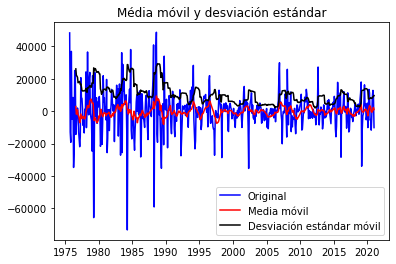

Resultados del test de Dickey-Fuller:
Estadístico de Prueba               -7.244628e+00
valor-p                              1.707560e-11
#Retardos utilizados                 1.100000e+01
Número de observaciones utilizado    5.330000e+02
Valor crítico (1%)                  -2.569948e+00
Valor crítico (5%)                  -1.941516e+00
Valor crítico (10%)                 -1.616331e+00
dtype: float64


In [37]:
test_stationarity(ts_diff)

In [44]:
auto_arima(ts_diff, information_criterion="aic")

ARIMA(order=(3, 0, 3), scoring_args={}, suppress_warnings=True)

In [40]:
model = ARIMA(ts_diff, order=(1,0,3), freq="M").fit()

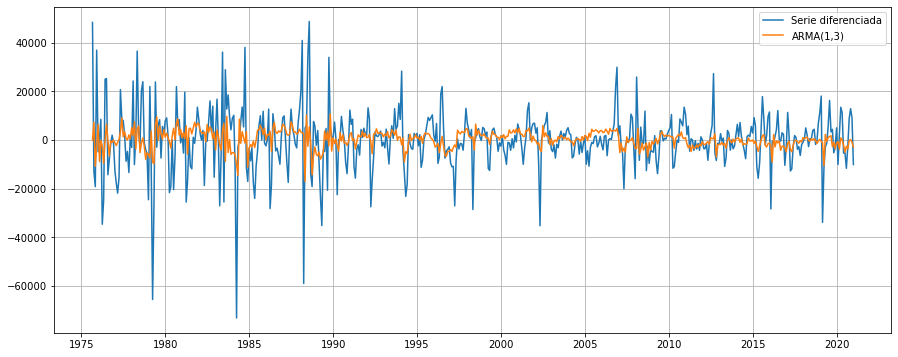

In [45]:
plt.figure(figsize=(15,6))
plt.plot(ts_diff, label="Serie diferenciada")
plt.plot(model.fittedvalues, label="ARMA(1,3)")
plt.grid()
plt.legend()

In [46]:
# Análisis de residuos del proceso ARMA(1,3)

In [47]:
np.mean(model.resid)

-366.3983720155688

In [48]:
np.std(model.resid)

11629.944059203342

In [49]:
print("Con el test de Shapiro-Wilk obtenemos un p-valor:", stats.shapiro(model.resid)[1])

Con el test de Shapiro-Wilk obtenemos un p-valor: 1.07106836415551e-17


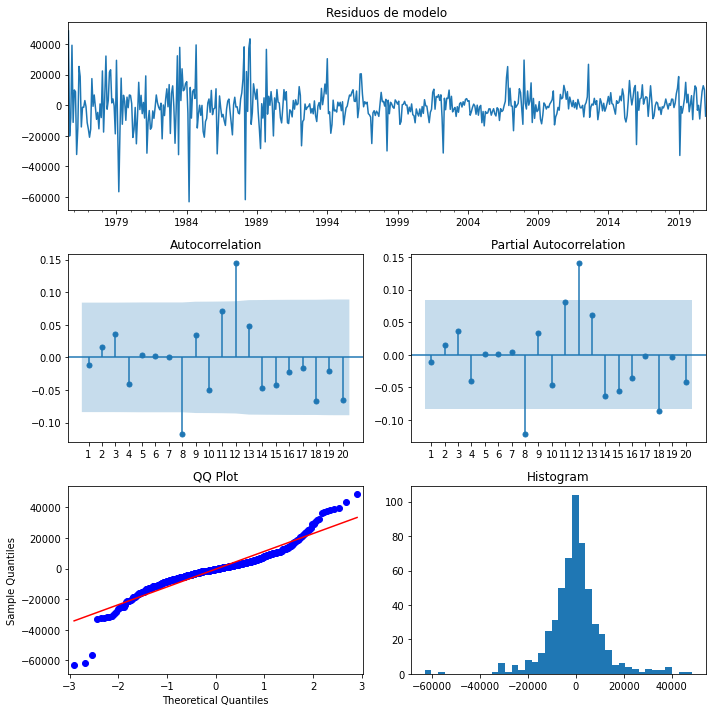

In [52]:
tsdisplay(model.resid)

In [53]:
model = ARIMA(ts_diff, order=(1,0,3), freq="M").fit()

In [58]:
model.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,-148.6022,126.230,-1.177,0.239,-396.008,98.803
ar.L1,0.8602,0.033,25.942,0.000,0.795,0.925
ma.L1,-0.7248,0.044,-16.513,0.000,-0.811,-0.639
ma.L2,-0.3159,0.033,-9.468,0.000,-0.381,-0.251
ma.L3,0.0619,0.039,1.591,0.112,-0.014,0.138
sigma2,1.288e+08,0.000,3.8e+11,0.000,1.29e+08,1.29e+08


# Serie diferenciada desde 1990 para hacer predicciones.

In [59]:
ts_show = ts_diff["Precio"]["1990-05-31":]
ts_show

1990-05-31      388.551185
1990-06-30     9711.364455
1990-07-31     4107.380502
1990-08-31       56.450038
1990-09-30    -9202.671659
                  ...     
2020-08-31    -2792.817962
2020-09-30     8779.211380
2020-10-31    12864.389866
2020-11-30     9162.164972
2020-12-31   -10130.036681
Freq: M, Name: Precio, Length: 368, dtype: float64

Haremos predicción considerando la serie desde 1990

Text(0.5, 1.0, 'Serie diferenciada desde 1900')

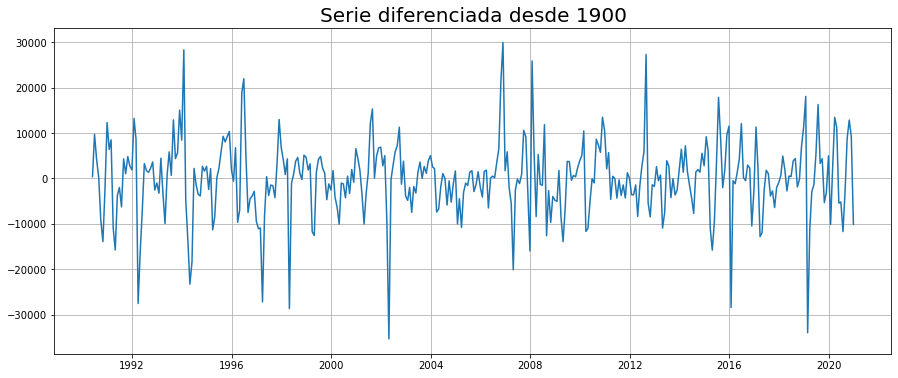

In [61]:
plt.figure(figsize=(15,6))
plt.plot(ts_show)
plt.grid()
plt.title("Serie diferenciada desde 1900", fontsize=20)

## Quitando el 5% de los datos

In [63]:
reales = ts_show[len(ts_show)-19:]

In [64]:
ts_show_1 = ts_show.iloc[:-18]

In [65]:
model_1 = ARIMA(ts_show_1, order=(2,0,1), freq="M").fit()

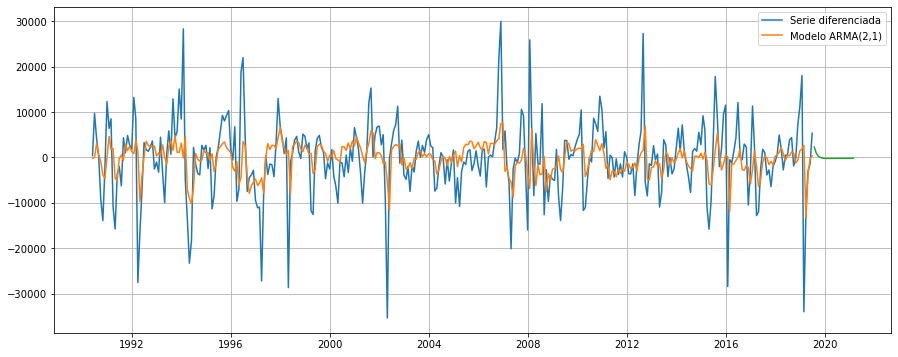

In [67]:
plt.figure(figsize=(15,6))
plt.plot(ts_show_1, label="Serie diferenciada")
plt.plot(model_1.fittedvalues, label = "Modelo ARMA(2,1)")
plt.plot(model_1.forecast(20))
plt.grid()
plt.legend()

In [68]:
prediccion = model_1.predict(start="2019-06-30", end="2020-12-31")

Text(0.5, 1.0, 'Predicción de la serie quitando el 5%')

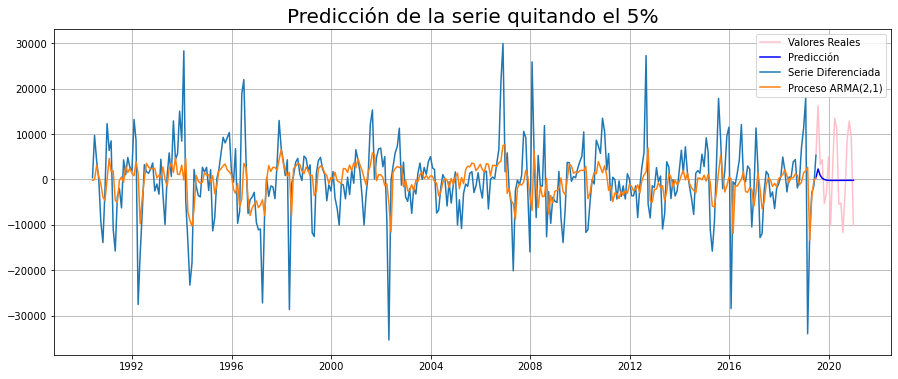

In [70]:
plt.figure(figsize=(15,6))
plt.plot(prediccion.index, reales.values, label="Valores Reales", color="pink")
plt.plot(prediccion.index, prediccion.values, label="Predicción", color="blue")
plt.plot(ts_show_1, label="Serie Diferenciada")
plt.plot(model_1.fittedvalues, label="Proceso ARMA(2,1)")
plt.grid()
plt.legend()
plt.title("Predicción de la serie quitando el 5%", fontsize=20)

# Quitando el 10% de los datos finales

In [73]:
reales = ts_show[len(ts_show)-39:]
ts_show_2 = ts_show.iloc[:-38]

In [74]:
model_2 = ARIMA(ts_show_2, order=(2,0,1), freq="M").fit()

In [75]:
prediccion = model_2.predict(start="2017-10-31", end="2020-12-31")

Text(0.5, 1.0, 'Predicción de la serie quitando el 10%')

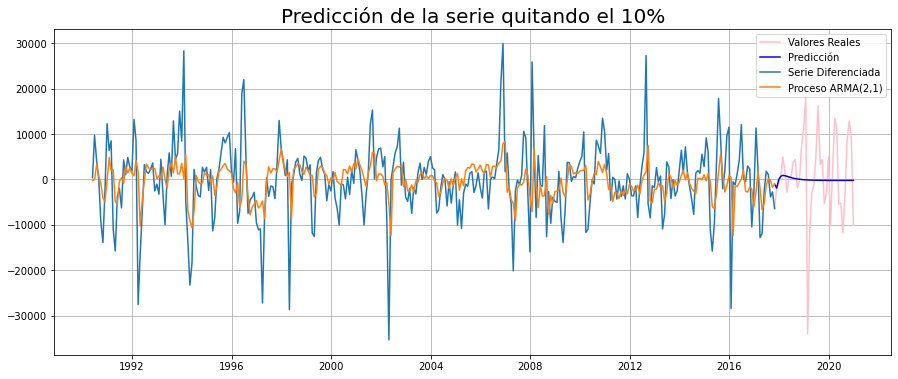

In [77]:
plt.figure(figsize=(15,6))
plt.plot(prediccion.index, reales.values, label="Valores Reales", color="pink")
plt.plot(prediccion.index, prediccion.values, label="Predicción", color="blue")
plt.plot(ts_show_2, label="Serie Diferenciada")
plt.plot(model_2.fittedvalues, label="Proceso ARMA(2,1)")
plt.grid()
plt.legend()
plt.title("Predicción de la serie quitando el 10%", fontsize=20)